# Importações

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import joblib
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

# Carregar e pré-processar o dataset

In [3]:
# Inicializar o stemmer
stemmer = PorterStemmer()

# Função para aplicar stemming em cada palavra da mensagem
def apply_stemming(text):
    # Verifica se o valor é string, caso contrário retorna texto vazio
    if isinstance(text, str):
        words = word_tokenize(text.lower())  # Tokeniza o texto
        stemmed_words = [stemmer.stem(word) for word in words]  # Aplica stemming em cada palavra
        return ' '.join(stemmed_words)
    else:
        print("erro")
        return ''  # Retorna string vazia se não for texto


In [5]:
# Carregar o dataset
df = pd.read_csv('enron_spam_data.csv', sep=',')

In [6]:
# Substituir valores nulos por strings vazias
df['Message'] = df['Message'].fillna('')

In [7]:
# Aplicar stemming nas mensagens
df['Message'] = df['Message'].apply(apply_stemming)

In [ ]:
# Salvar arquivo pós-processamento
# df.to_csv('datasetPronto.csv', index=False)

In [7]:
print(df['Message'])

0                                                         
1        gari , product from the high island larger blo...
2                          - calpin daili ga nomin 1 . doc
3        fyi - see note below - alreadi done . stella -...
4        fyi . - - - - - - - - - - - - - - - - - - - - ...
                               ...                        
33711    hello , welcom to gigapharm onlinn shop . pres...
33712    i got it earlier than expect and it wa wrap ca...
33713    are you readi to rock on ? let the man in you ...
33714    learn how to last 5 - 10 time longer in bed . ...
33715    hi : ) do you need some softwar ? i can give y...
Name: Message, Length: 33716, dtype: object


In [8]:
# Separar as features e os rótulos
X = df['Message']
y = df['Spam/Ham'].apply(lambda x: 1 if x == 'spam' else 0)

In [9]:
# Dividir o dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Transformar o texto em vetores de TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Treinar o modelo SVM com kernel RBF


In [10]:
# Inicializar o modelo SVM com kernel RBF
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # C é o parâmetro de regularização

In [ ]:
# Treinar o modelo
svm_model.fit(X_train_tfidf, y_train)

In [ ]:
# Salvar o modelo em um arquivo
joblib.dump(svm_model, 'modelo_sem_ajuste_sem_kfold-c1-gSC.pkl')
joblib.dump(vectorizer, 'vectorizer_sem_ajuste_sem_kfold-c1-gSC.pkl')

In [ ]:
#Carregar modelo
svm_model = joblib.load('modelo_sem_ajuste_sem_kfold-c1-gSC.pkl')
vectorizer = joblib.load('vectorizer_sem_ajuste_sem_kfold-c1-gSC.pkl')

In [13]:
# Fazer previsões no conjunto de teste
y_pred = svm_model.predict(X_test_tfidf)
probabilities = svm_model.predict_proba(X_test_tfidf)

In [5]:
testSpam = """
Dear Valued Customer,

We are thrilled to inform you that you've been selected as the lucky winner of a $1000 gift card to spend at your favorite stores!

To claim your prize, all you need to do is click the link below and provide your information. This offer is exclusive and limited, so don't miss out on this amazing opportunity!

[Click Here to Claim Your Prize Now!]

Remember, this offer is only valid for a short time. Act fast to ensure you receive your gift card!

Best regards,
The Rewards Team
"""

In [6]:
testHam = """
Hi Team,

I hope this message finds you well.

I wanted to remind everyone about our scheduled team meeting this Friday, October 13th, at 10:00 AM in the main conference room. The main focus will be to review the progress of our current projects, address any blockers, and align on upcoming deadlines.

Please come prepared to share a brief update on your current tasks, and if there are any issues that need attention, feel free to bring them up during the discussion.

Let me know if you're unable to attend or need any specific materials ahead of time.

Looking forward to seeing everyone there!

Best regards,
John
"""

In [9]:
testSpam = apply_stemming(testSpam)
testHam = apply_stemming(testHam)

testl = vectorizer.transform([testSpam, testHam])  # Note a mudança para uma lista
y_pred = svm_model.predict(testl)
probabilities = svm_model.predict_proba(testl)

In [10]:
print(y_pred)
print(probabilities)

[1 0]


In [ ]:
# Avaliar o modelo
print(f"Acurácia: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

In [16]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

In [17]:
# Criar um objeto de exibição da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])

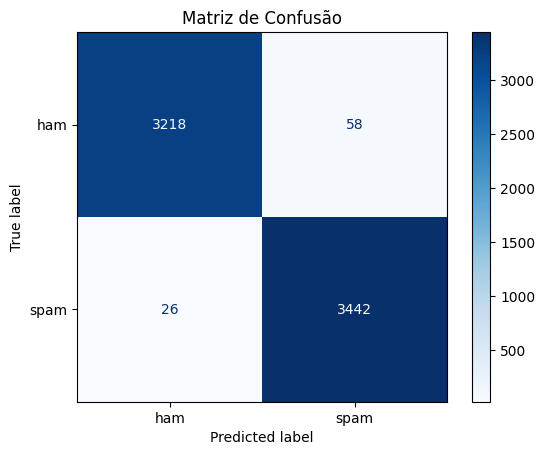

In [33]:
# Plotar a matriz de confusão
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

## Ajustar os Hiperparâmetros

In [20]:
# Definir os parâmetros a serem testados
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

In [21]:
# Usar o GridSearchCV para encontrar os melhores parâmetros
grid_search = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=5, 
    verbose=1, 
    n_jobs=-1, 
    scoring=scoring, 
    return_train_score=True, 
    refit='f1'
)

grid_search.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'},
             verbose=1)

In [23]:
grid_search = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=5, 
    verbose=1, 
    n_jobs=-1, 
    scoring=scoring, 
    return_train_score=True, 
    refit=False
)

grid_search.fit(X_train_tfidf, y_train)

# Acessando os resultados e calculando a média das métricas para cada combinação
results = grid_search.cv_results_
for i in range(len(results['params'])):
    mean_score = (
        results['mean_test_accuracy'][i] + 
        results['mean_test_precision'][i] + 
        results['mean_test_recall'][i] + 
        results['mean_test_f1'][i]
    ) / 4  # Média das métricas
    print(f"Parâmetros: {results['params'][i]}, Média das métricas: {mean_score}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Parâmetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}, Média das métricas: 0.9609661647592878
Parâmetros: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}, Média das métricas: 0.6724676793377675
Parâmetros: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}, Média das métricas: 0.7109948027918578
Parâmetros: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}, Média das métricas: 0.9406833248325732
Parâmetros: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}, Média das métricas: 0.9610617361901026
Parâmetros: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}, Média das métricas: 0.985731577169465
Parâmetros: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}, Média das métricas: 0.6724676793377675
Parâmetros: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}, Média das métricas: 0.9456545569454362
Parâmetros: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}, Média das métricas: 0.9784093275813021
Parâmetros: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}, Média das métricas: 0.98577043874404

In [36]:
from operator import itemgetter

mean_scores = []

for i in range(len(results['params'])):
    accuracy = results['mean_test_accuracy'][i]
    precision = results['mean_test_precision'][i]
    recall = results['mean_test_recall'][i]
    f1 = results['mean_test_f1'][i]
    
    mean_score = (accuracy + precision + recall + f1) / 4  # Média das métricas
    mean_scores.append((results['params'][i], mean_score, accuracy, precision, recall, f1))

# Ordenar as médias em ordem decrescente e pegar as três maiores
top_3 = sorted(mean_scores, key=itemgetter(1), reverse=True)

# Imprimir as três maiores médias com os parâmetros e métricas correspondentes
for params, mean_score, accuracy, precision, recall, f1 in top_3:
    print(f"Parâmetros: {params}")
    print(f"  Média das métricas: {mean_score:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("\n")

Parâmetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
  Média das métricas: 0.9880
  Accuracy: 0.9878
  Precision: 0.9802
  Recall: 0.9961
  F1 Score: 0.9881


Parâmetros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
  Média das métricas: 0.9875
  Accuracy: 0.9872
  Precision: 0.9793
  Recall: 0.9960
  F1 Score: 0.9876


Parâmetros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
  Média das métricas: 0.9875
  Accuracy: 0.9872
  Precision: 0.9795
  Recall: 0.9957
  F1 Score: 0.9876


Parâmetros: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
  Média das métricas: 0.9874
  Accuracy: 0.9871
  Precision: 0.9773
  Recall: 0.9977
  F1 Score: 0.9874


Parâmetros: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
  Média das métricas: 0.9874
  Accuracy: 0.9871
  Precision: 0.9773
  Recall: 0.9977
  F1 Score: 0.9874


Parâmetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Média das métricas: 0.9873
  Accuracy: 0.9870
  Precision: 0.9773
  Recall: 0.9977
  F1 Score: 0.9874


Parâmetros: {'C': 100, 'gamma': 'scale', '

In [24]:
# Ver os melhores parâmetros
print(f"Melhores parâmetros: {grid_search.best_params_}")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
# Treinar o modelo com os melhores parâmetros
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_tfidf, y_train)

In [ ]:
# Salvar o modelo otimizado em um arquivo
joblib.dump(best_svm_model, 'modelo_com_ajuste_e_kfold.pkl')
joblib.dump(vectorizer, 'vectorizer_com_ajuste_e_kfold.pkl')

In [ ]:
# best_svm_model = joblib.load('modelo_treinado.pkl')

In [ ]:
# Avaliar o modelo otimizado
y_pred_optimized = best_svm_model.predict(X_test_tfidf)
print(f"Acurácia: {accuracy_score(y_test, y_pred_optimized) * 100:.2f}%")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_optimized, target_names=['ham', 'spam']))

In [ ]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred_optimized, labels=['ham', 'spam'])# Matriz de 

In [ ]:
# Criar um objeto de exibição da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])

In [ ]:
# Plotar a matriz de confusão
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()